## Trabajar con modelos

### Modelo 0 - Constante

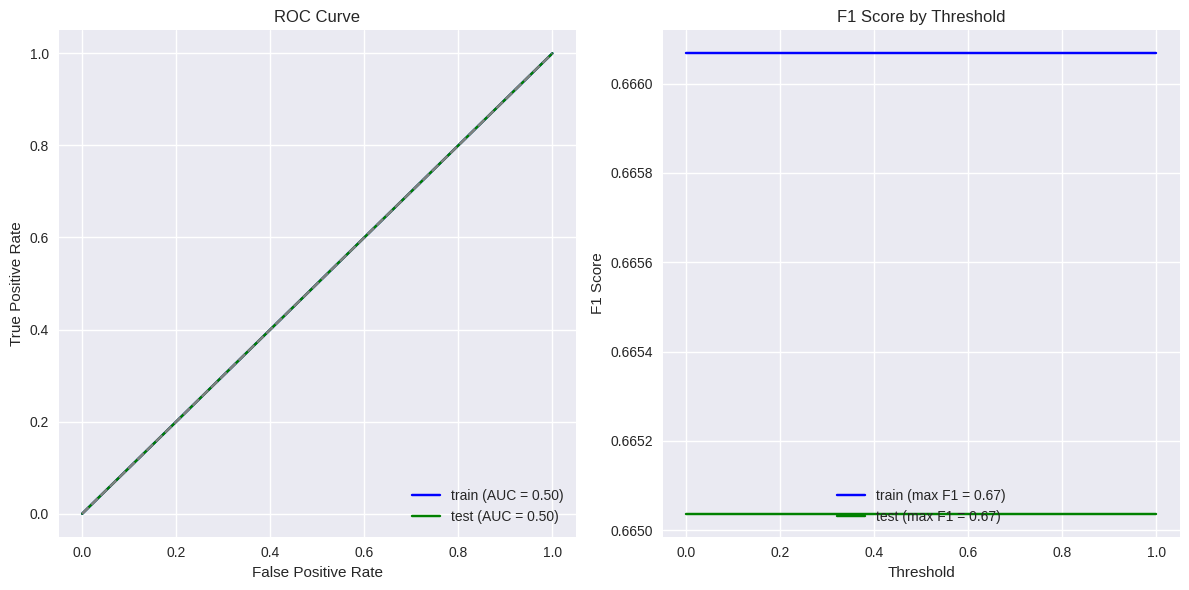

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
ROC AUC    0.50  0.50


In [24]:
# Definir modelo dummy como dummy_clf con constant = 1
dummy_clf = DummyClassifier(strategy='constant', constant=1)

# Entrenar modelo dummy
dummy_clf_trained = dummy_clf.fit(X=df_reviews_train, y=train_target)

# Usar la función simplificada 'evaluate_model_simplified' para evaluar el modelo dummy
evaluate_model_simplified(dummy_clf_trained, np.zeros((len(train_target), 1)), train_target, np.zeros((len(test_target), 1)), test_target)

La evaluación del modelo dummy demuestra un rendimiento de referencia, donde se clasifica todas las observaciones en una única clase constante (en este caso, 1). 
Este enfoque permite comparar la efectividad de modelos más avanzados al ofrecer un punto de referencia básico para la predicción.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [25]:
# Convertir las listas de tokens a cadenas de texto para ser procesadas por el vectorizador TF-IDF
df_reviews_train['final_review_text'] = df_reviews_train['final_review'].apply(lambda x: ' '.join(x))
df_reviews_test['final_review_text'] = df_reviews_test['final_review'].apply(lambda x: ' '.join(x))

# Inicializar y ajustar el vectorizador TF-IDF, eliminar stop words en inglés y cambiar letras a minúsculas
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, lowercase= True, max_features=5000)
train_features_vectorized = tfidf_vectorizer.fit_transform(df_reviews_train['final_review_text'])
test_features_vectorized = tfidf_vectorizer.transform(df_reviews_test['final_review_text'])

# Motrar dimensiones de los conjuntos de entrenamiento y prueba vectorizados
print(train_features_vectorized.shape)
print(test_features_vectorized.shape)

(23760, 5000)
(23486, 5000)


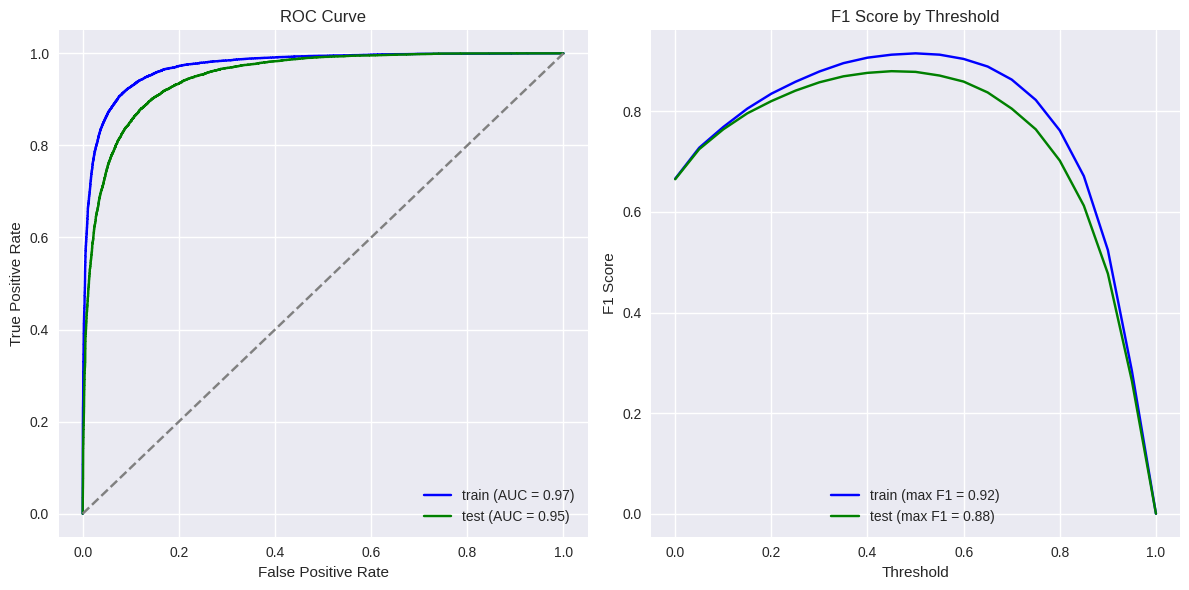

          train  test
Accuracy   0.91  0.88
F1         0.92  0.88
ROC AUC    0.97  0.95


In [26]:
# Entrenar el modelo
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_features_vectorized, df_reviews_train['pos'])

# Evaluar el modelo de Regresión Logística con la función simplificada
evaluate_model_simplified(log_reg, train_features_vectorized, df_reviews_train['pos'], test_features_vectorized, df_reviews_test['pos'])

El código convierte listas de tokens en cadenas de texto, vectoriza las reseñas con TF-IDF, entrena un modelo de regresión logística y evalúa su desempeño. 
Esto proporciona un enfoque estructurado para analizar y clasificar reseñas, garantizando una evaluación efectiva del modelo de aprendizaje automático.

### Modelo 3 - spaCy, TF-IDF y LR

/opt/conda/envs/python3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


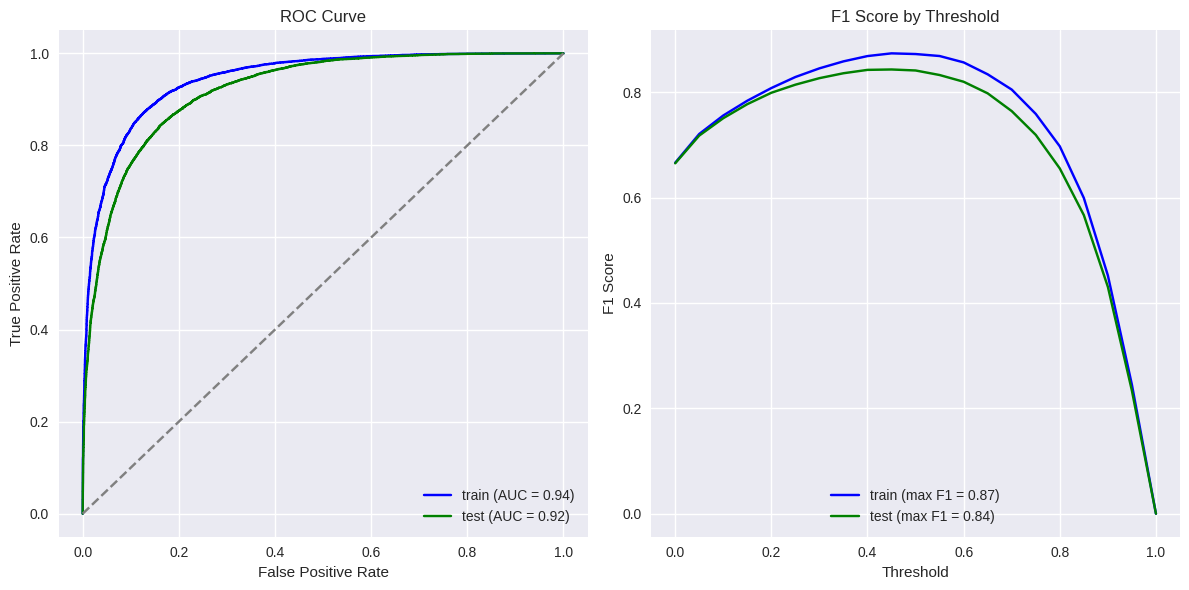

          train  test
Accuracy   0.87  0.84
F1         0.87  0.84
ROC AUC    0.94  0.92


In [27]:
# Cargar el modelo spaCy pequeño para ahorrar tiempo y recursos
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'tagger'])

# Función para convertir el texto en minúsculas, eliminar stopwords y tokens no alfabéticos, y aplicar lematización
def text_preprocessing_3(text):
    doc = nlp(text.lower()[:1000])  # Limitar a los primeros 1000 caracteres
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

# Procesar los datos en paralelo
def parallel_preprocessing(texts, n_jobs=-1):
    return Parallel(n_jobs=n_jobs)(delayed(text_preprocessing_3)(text) for text in texts)

# Aplicar la función de preprocesamiento a las reseñas
df_reviews_train['review_tokenized_3'] = parallel_preprocessing(df_reviews_train['review'])
df_reviews_test['review_tokenized_3'] = parallel_preprocessing(df_reviews_test['review'])

# Vectorización con TF-IDF
tfidf_vectorizer_3 = TfidfVectorizer(max_features=2000)  # Reducir a 2000 características
train_corpus_3 = df_reviews_train['review_tokenized_3']
test_corpus_3 = df_reviews_test['review_tokenized_3']

train_features_3 = tfidf_vectorizer_3.fit_transform(train_corpus_3)
test_features_3 = tfidf_vectorizer_3.transform(test_corpus_3)

# Definir el modelo de regresión logística
model_lr = LogisticRegression()

# Entrenar el modelo de regresión logística con las características vectorizadas y etiquetas del objetivo de entrenamiento
model_lr.fit(train_features_3, df_reviews_train['pos'])

# Evaluar el modelo utilizando la función predefinida
evaluate_model_simplified(model_lr, train_features_3, df_reviews_train['pos'], test_features_3, df_reviews_test['pos'])

El código preprocesa las reseñas con spaCy, vectoriza los textos con TF-IDF, entrena un modelo de regresión logística con 2000 características para ahorrar memoria y evalúa su desempeño. 
Esto optimiza la clasificación de reseñas, combinando técnicas de NLP y aprendizaje automático.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

/opt/conda/envs/python3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


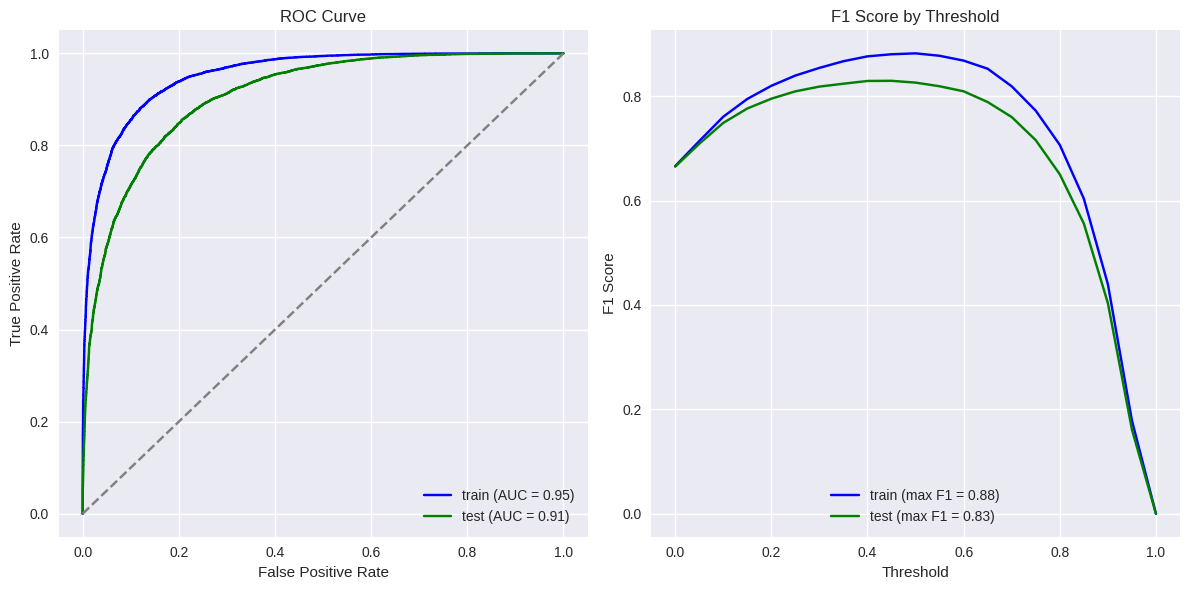

          train  test
Accuracy   0.88  0.82
F1         0.88  0.83
ROC AUC    0.95  0.91


In [28]:
# Aplicar la función de preprocesamiento a las reseñas
df_reviews_train['review_tokenized_4'] = parallel_preprocessing(df_reviews_train['review'])
df_reviews_test['review_tokenized_4'] = parallel_preprocessing(df_reviews_test['review'])

# Vectorización con TF-IDF
tfidf_vectorizer_4 = TfidfVectorizer(max_features=2000)  # Reducir a 2000 características
train_corpus_4 = df_reviews_train['review_tokenized_4']
test_corpus_4 = df_reviews_test['review_tokenized_4']

# Entrenamiento del modelo
train_features_4 = tfidf_vectorizer_4.fit_transform(train_corpus_4)
test_features_4 = tfidf_vectorizer_4.transform(test_corpus_4)

# Definir el modelo LGBMClassifier
model_lgbm = LGBMClassifier()

# Entrenar el modelo LGBMClassifier con las características vectorizadas y etiquetas del objetivo de entrenamiento
model_lgbm.fit(train_features_4, df_reviews_train['pos'])

# Evaluar el modelo utilizando la función simplificada
evaluate_model_simplified(model_lgbm, train_features_4, df_reviews_train['pos'], test_features_4, df_reviews_test['pos'])



Este modelo preprocesa las reseñas con funciones paralelas, las vectoriza con TF-IDF limitando a 2000 características para ahorrar memoria y entrena un modelo LGBMClassifier. Finalmente, se evalúa el desempeño.

###  Modelo 9 - BERT

In [29]:
# Inicialización del tokenizador y selección del modelo BertModel
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
# Función para transformar lista de textos a embeddings usando un modelo BERT con parámetros seleccionados para ahorrar memoria
def BERT_text_to_embeddings(texts, max_length=128, batch_size=5, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    # Configuración de logging para suprimir algunos mensajes de advertencia
    logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

    # Procesar cada texto individualmente
    for text in texts:
        ids = tokenizer.encode(text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        # Padding
        padded = np.array(ids[:max_length] + [0] * (max_length - len(ids)))
        # Crear la máscara de atención
        attention_mask = np.where(padded != 0, 1, 0)

        # Agregar ids y la máscara a las listas
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    # Dispositivo
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # Obtener embeddings en lotes
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size * i: batch_size * (i + 1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i: batch_size * (i + 1)]).to(device)
                    
        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())
        
        # Liberar memoria
        del ids_batch, attention_mask_batch, batch_embeddings
        torch.cuda.empty_cache()
        
    return np.concatenate(embeddings)

In [31]:
# Segmentación de datos para incluir sólo 20 datos para utilizar BERT
df_reviews_train_sample = df_reviews_train['final_review_text'].iloc[0:20]
df_reviews_test_sample = df_reviews_test['final_review_text'].iloc[0:20]

# Obtener embeddings para el conjunto de entrenamiento
train_features_9 = BERT_text_to_embeddings(df_reviews_train_sample, max_length=128, batch_size=5, force_device=None, disable_progress_bar=False)

# Obtener embeddings para el conjunto de prueba
test_features_9 = BERT_text_to_embeddings(df_reviews_test_sample, max_length=128, batch_size=5, force_device=None, disable_progress_bar=False)

# Definir el objetivo
target_9 = df_reviews.iloc[0:20]['pos']

Uso del dispositivo cpu.


  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_50/2724887742.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  ids_batch = torch.LongTensor(ids_list[batch_size * i: batch_size * (i + 1)]).to(device)


Uso del dispositivo cpu.


  0%|          | 0/4 [00:00<?, ?it/s]

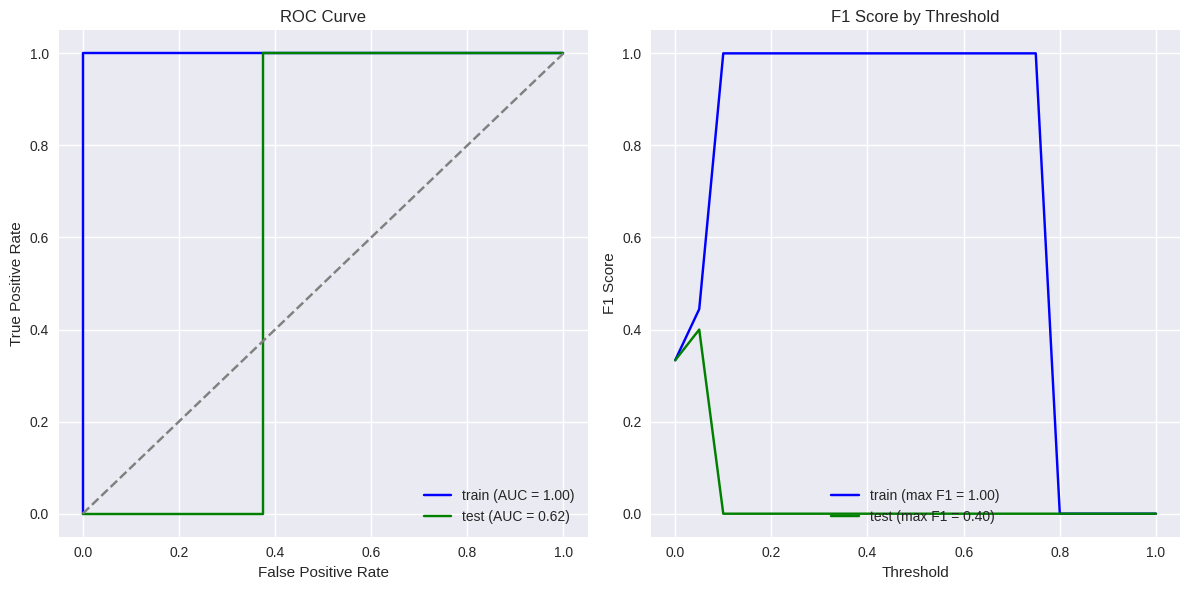

          train  test
Accuracy    1.0  0.80
F1          1.0  0.00
ROC AUC     1.0  0.62


In [32]:
# División de datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(train_features_9, target_9, test_size=0.5, random_state=42)

# Entrenamiento del modelo
model_9 = LogisticRegression()
model_9.fit(X_train, y_train)

# Evaluación del modelo
pred_9 = model_9.predict(X_train)
evaluate_model_simplified(model_9, X_train, y_train, X_test, y_test)

In [33]:
# Guardar los embeddings
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# Cargar los embeddings cuando los necesites
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

El modelo convierte textos en embeddings utilizando BERT, segmenta los datos en conjuntos de entrenamiento y prueba, entrena un modelo de regresión logística y evalúa su desempeño. 
Este enfoque optimiza la clasificación de reseñas mediante el uso de NLP y aprendizaje automático.

### Conclusión de trabajar con modelos

De los 5 modelos entrenados, el que supera el umbral de al menos 0.85 de F1 score es el modelo 1 o NLTK TF-IDF y LR, siendo el más prometedor.

En el caso de BERT, debido a que el kernel dejaba de funcionar se optó por ahorrar la mayor cantidad de memoria posible. 
De manera similar en lso modelos se limitaron las características a un máximo de 2000 para evitar que el Kernel muriera.

## Mis reseñas

In [34]:
# Código preecargado, puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['cleaned_review'] = my_reviews['review'].apply(clean_text)
my_reviews['tokenized_review'] = my_reviews['cleaned_review'].apply(nltk.word_tokenize)
my_reviews['lemmatized_review'] = my_reviews['tokenized_review'].apply(lemmatize_tokens)
my_reviews['final_review'] = my_reviews['lemmatized_review'].apply(remove_stopwords)
my_reviews['final_review_text'] = my_reviews['final_review'].apply(lambda x: ' '.join(x))

# Vectorización de las reseñas con TF-IDF
my_reviews_vectorized = tfidf_vectorizer.transform(my_reviews['final_review_text'])

# Clasificación de las reseñas con el modelo entrenado
my_reviews_predictions = log_reg.predict(my_reviews_vectorized)

# Agregar las predicciones al DataFrame
my_reviews['predicted_sentiment'] = my_reviews_predictions

print(my_reviews[['review', 'predicted_sentiment']])

                                              review  predicted_sentiment
0    I did not simply like it, not my kind of movie.                    0
1  Well, I was bored and felt asleep in the middl...                    0
2             I was really fascinated with the movie                    1
3  Even the actors looked really old and disinter...                    0
4  I didn't expect the reboot to be so good! Writ...                    0
5  The movie had its upsides and downsides, but I...                    1
6  What a rotten attempt at a comedy. Not a singl...                    0
7  Launching on Netflix was a brave move & I real...                    1


Se preprocesa y vectoriza las reseñas de ejemplo y se utiliza un modelo entrenado para predecir el sentimiento de cada reseña. Las predicciones se agregan al DataFrame, permitiendo la clasificación de las reseñas basadas en el modelo de aprendizaje automático.

### Ejemplo utilizando el Modelo 1 (NLTK, TF-IDF y LR)

In [35]:
# Obtener los textos de las reseñas procesadas
texts = my_reviews['final_review_text']

# Obtener las probabilidades de predicción
my_reviews_pred_prob = log_reg.predict_proba(tfidf_vectorizer.transform(texts))[:, 1]

# Imprimir las probabilidades de predicción junto con las reseñas (primeros 100 caracteres)
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


0.20:  simply like kind movie
0.15:  well wa bored felt asleep middle movie
0.54:  wa really fascinated movie
0.10:  even actor looked really old disinterested got paid movie soulless cash grab
0.20:  didnt expect reboot good writer really cared source material
0.57:  movie upside downside feel like overall decent flick could see going see
0.05:  rotten attempt comedy single joke land everyone act annoying loud even kid wont like
0.95:  launching netflix wa brave move really appreciate able binge episode episode exciting intelligent ne


Las reseñas se procesan en probabilidades de predicción mediante un modelo de regresión logística entrenado, y se imprimen estas probabilidades junto con las reseñas.

### Modelo 3 spaCy, TF-IDF y LR

In [36]:
# Obtener los textos de las reseñas procesadas
texts = my_reviews['final_review_text']

# Preprocesar y vectorizar los textos de las reseñas
texts_preprocessed = texts.apply(lambda x: text_preprocessing_3(x))
texts_features = tfidf_vectorizer_3.transform(texts_preprocessed)

# Obtener las probabilidades de predicción
my_reviews_pred_prob = model_lr.predict_proba(texts_features)[:, 1]

# Imprimir las Probabilidades de Predicción con las Reseñas:
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


0.15:  simply like kind movie
0.10:  well wa bored felt asleep middle movie
0.41:  wa really fascinated movie
0.06:  even actor looked really old disinterested got paid movie soulless cash grab
0.40:  didnt expect reboot good writer really cared source material
0.28:  movie upside downside feel like overall decent flick could see going see
0.03:  rotten attempt comedy single joke land everyone act annoying loud even kid wont like
0.93:  launching netflix wa brave move really appreciate able binge episode episode exciting intelligent ne


/opt/conda/envs/python3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


El ejemplo de modelo preprocesa y vectoriza las reseñas, luego utiliza un modelo de regresión logística para predecir las probabilidades de sentimiento.

### Modelo 4 spaCy, TF-IDF y LGBMClassifier

In [37]:
# Obtener los textos de las reseñas procesadas
texts = my_reviews['final_review_text']

# Preprocesar y vectorizar los textos de las reseñas
texts_preprocessed = texts.apply(lambda x: text_preprocessing_3(x))
texts_features = tfidf_vectorizer_4.transform(texts_preprocessed)

# Obtener las probabilidades de predicción con el modelo LGBMClassifier
my_reviews_pred_prob = model_lgbm.predict_proba(texts_features)[:, 1]

# Imprimir las Probabilidades de Predicción con las Reseñas:
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


0.56:  simply like kind movie
0.37:  well wa bored felt asleep middle movie
0.61:  wa really fascinated movie
0.33:  even actor looked really old disinterested got paid movie soulless cash grab
0.61:  didnt expect reboot good writer really cared source material
0.49:  movie upside downside feel like overall decent flick could see going see
0.10:  rotten attempt comedy single joke land everyone act annoying loud even kid wont like
0.74:  launching netflix wa brave move really appreciate able binge episode episode exciting intelligent ne


Se preprocesa y vectoriza las reseñas, luego se utiliza un modelo LGBMClassifier para predecir las probabilidades de sentimiento.

### Modelo 9 BERT

In [38]:
# Extracción de texto 
texts = my_reviews['final_review_text']

#Conversión de textos a embeddings
my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# Predicción de probabilidad para cada clase
my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.03:  simply like kind movie
0.05:  well wa bored felt asleep middle movie
0.11:  wa really fascinated movie
0.21:  even actor looked really old disinterested got paid movie soulless cash grab
0.05:  didnt expect reboot good writer really cared source material
0.06:  movie upside downside feel like overall decent flick could see going see
0.12:  rotten attempt comedy single joke land everyone act annoying loud even kid wont like
0.14:  launching netflix wa brave move really appreciate able binge episode episode exciting intelligent ne


El modelo preprocesa las reseñas con BERT para obtener embeddings, luego utiliza un modelo de regresión logística entrenado para predecir las probabilidades de sentimiento.